# Context-sensitive Spelling Correction

### Not a mere code copy-paste from somewhere
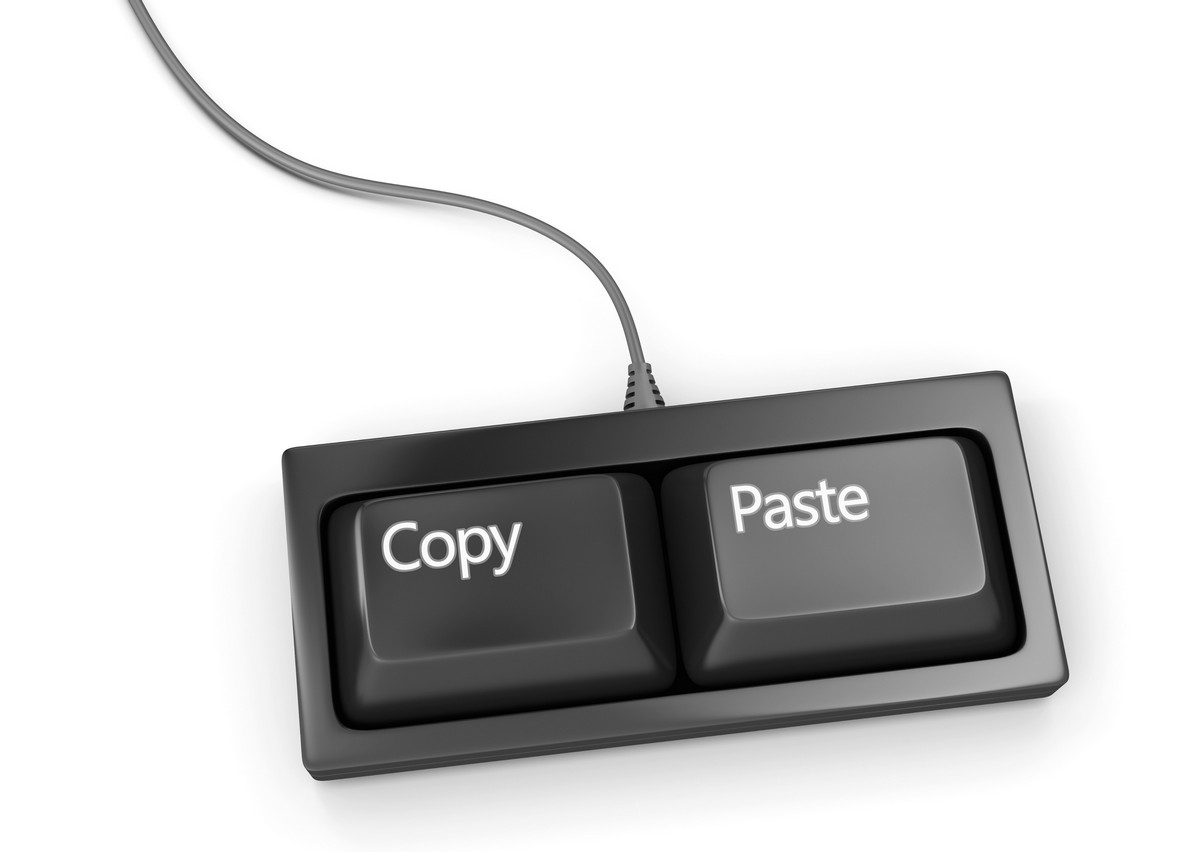

In the future, I plan to use bigrams, as it was said at the lecture that it is difficult with 5 grams.

In [1]:
import pandas as pd
import numpy as np
import json
import re
import nltk
from nltk.corpus import words
import requests
import os

from collections import defaultdict, Counter

nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Bigrams count reduction: 1020385 -> 522068

In [2]:
df = pd.read_csv('./data/bigrams.txt', sep='\t', header=None, encoding='latin-1')
df.columns = ['count', 'word1', 'word2']

df['word1'] = df['word1'].str.lower()
df['word2'] = df['word2'].str.lower()

df = df[df['word1'].isin(words.words()) & df['word2'].isin(words.words())]

df['bigram'] = df.apply(lambda row: tuple(sorted([row['word1'], row['word2']])), axis=1)
df = df.groupby('bigram')['count'].sum().reset_index()

df['word1'] = df['bigram'].apply(lambda x: x[0])
df['word2'] = df['bigram'].apply(lambda x: x[1])

word_counter = Counter()
word_counter.update(df['word1'].value_counts().to_dict())
word_counter.update(df['word2'].value_counts().to_dict())
bigram_counter = Counter(df.set_index('bigram')['count'].to_dict())

print(f"Loaded {len(word_counter)} unique words.")
print(f"Loaded {len(bigram_counter)} unique bigrams.")

Loaded 26900 unique words.
Loaded 522068 unique bigrams.


In [3]:
def P_word(word, N_words=sum(word_counter.values())):
    return np.log((1 + word_counter[word.lower()]) / N_words)

def P_bigram(bigram, N_BIGRAMS=sum(bigram_counter.values())):
    bigram = tuple(map(str.lower, bigram))
    bigram = tuple(sorted(bigram)) 
    return np.log(1 + bigram_counter[bigram]) + P_word(bigram[0]) + P_word(bigram[1])

def P_sent(sentence):
    sentence = list(map(str.lower, sentence))  
    if len(sentence) < 2:
        return float('-inf')
    
    prob = 0.0
    for i in range(len(sentence) - 1):
        bigram = (sentence[i], sentence[i + 1])
        prob += P_bigram(bigram)
    
    return prob

In [4]:
from collections import defaultdict, deque
from itertools import product
import heapq

def load_dict(filename):
    with open(filename, 'r') as fp:
        content = fp.read()
        content = re.sub(r"'", '"', content)
        prem_dict = json.loads(content)
        ret_dict = {(k[0], k[1]): v for k, v in prem_dict.items()}
        return ret_dict

subconfusion = load_dict('./data/subconfusion.data')
revconfusion = load_dict('./data/revconfusion.data')
delconfusion = load_dict('./data/delconfusion.data')
addconfusion = load_dict('./data/addconfusion.data')

# Edit probabilities (example values; load from data in practice)
EDIT_PROB = {
    'substitution': subconfusion,
    'deletion': delconfusion,
    'insertion': addconfusion,
    'transposition': revconfusion
}

def compute_chars_count(word_counter):
    """
    Compute character and character-pair frequencies from word_counter.
    """
    chars = defaultdict(int)
    char_pairs = defaultdict(int)
    
    for word, count in word_counter.items():
        for i, char in enumerate(word):
            chars[char] += count
            if i > 0:
                char_pairs[(word[i-1], char)] += count
    
    return dict(chars), dict(char_pairs)

def normalize_edit_probabilities(EDIT_PROB, chars, char_pairs, eps=1e-8):
    """
    Normalize the probabilities in EDIT_PROB using the provided chars and char_pairs frequencies.
    Add smoothing with eps to avoid division by zero.
    """
    for edit_type, matrix in EDIT_PROB.items():
        if edit_type == 'deletion':
            for (x, y), count in matrix.items():
                matrix[(x, y)] = np.log((count + eps) / (char_pairs.get((x, y), eps) + eps))
        elif edit_type == 'insertion':
            for (x, y), count in matrix.items():
                matrix[(x, y)] = np.log((count + eps) / (chars.get(x, eps) + eps))
        elif edit_type == 'substitution':
            for (x, y), count in matrix.items():
                matrix[(x, y)] = np.log((count + eps) / (chars.get(x, eps) + eps))
        elif edit_type == 'transposition':
            for (x, y), count in matrix.items():
                matrix[(x, y)] = np.log((count + eps) / (char_pairs.get((x, y), eps) + eps))

chars, char_pairs = compute_chars_count(word_counter)

normalize_edit_probabilities(EDIT_PROB, chars, char_pairs)

In [5]:
MAX_EDIT_DIST = 2
LOG_UNREACHABLE_THRESH = -30 * MAX_EDIT_DIST

In [6]:
def generate_edit_sequences(w: str, max_edit_distance: int = MAX_EDIT_DIST, prob_threshold: float = LOG_UNREACHABLE_THRESH) -> list:
    """
    Generate all valid edit sequences transforming w into c, within max_edit_distance.
    Prune low-probability paths and ensure candidates are in word_counter.keys().
    """

    valid_candidates = set(word_counter.keys())
    sequences = {}
    queue = [(0.0, 0, w)]
    sequences[w] = 0.0
    while queue:
        neg_prob, dist, current_word = heapq.heappop(queue)

        if neg_prob < prob_threshold:
            continue

        if current_word in word_counter.keys():
            sequences[current_word] = max(neg_prob, sequences.get(current_word, float("-inf")))

        if dist >= max_edit_distance:
            continue

        for i in range(len(current_word)):
            deleted = current_word[:i] + current_word[i+1:]
            del_prob = EDIT_PROB['deletion'].get((current_word[i - 1] if i - 1 >= 0 else ".", current_word[i]), -50)
            heapq.heappush(queue, (neg_prob + del_prob, dist + 1,
                                   deleted))

            for char in 'abcdefghijklmnopqrstuvwxyz':
                substituted = current_word[:i] + char + current_word[i+1:]
                sub_prob = EDIT_PROB['substitution'].get((current_word[i], char), -50)
                heapq.heappush(queue, (neg_prob + sub_prob, dist + 1,
                                       substituted))

            for char in 'abcdefghijklmnopqrstuvwxyz':
                inserted = current_word[:i] + char + current_word[i:]
                ins_prob = EDIT_PROB['insertion'].get((current_word[i], char), -50)
                heapq.heappush(queue, (neg_prob + ins_prob,
                                       dist + 1, inserted))

            if i < len(current_word) - 1:
                transposed = current_word[:i] + current_word[i + 1] + current_word[i] + current_word[i+2:]
                trans_prob = EDIT_PROB['transposition'].get((current_word[i], current_word[i+1]), -50)
                heapq.heappush(
                    queue, (neg_prob + trans_prob, dist + 1, transposed))

    return sequences

In [7]:
def spell_correct_sentence(sentence: str, max_edit_distance: int = MAX_EDIT_DIST,
                           prob_threshold: float = LOG_UNREACHABLE_THRESH, lambda_param: float = 0.65,
                           confidence_threshold: float = 1.05, immediate_threshold: float = 1.5) -> str:
    """
    Correct spelling errors in a sentence using combined context and edit probabilities.

    Args:
        sentence: Input sentence to correct
        max_edit_distance: Maximum number of edits allowed per word
        prob_threshold: Minimum probability threshold for edit sequences
        lambda_param: Weighting between context and edit probabilities (0.0-1.0)
        confidence_threshold: Minimum confidence to accept a correction
        immediate_threshold: Minimum confidence to immediately accept change and continue corrections taking it into account

    Returns:
        Corrected sentence
    """
    sent_words = sentence.split()
    result = []

    for i in range(len(sent_words)):
        original_word = sent_words[i]

        # Generate candidate corrections
        candidates = generate_edit_sequences(
            original_word,
            max_edit_distance=max_edit_distance,
            prob_threshold=prob_threshold
        )

        if not candidates:
            continue

        # Calculate context probabilities for each candidate
        context_probs = {}
        for candidate, edit_prob in candidates.items():
            context = []
            if i > 0:
                context.append(sent_words[i-1])
            context.append(candidate)
            if i < len(sent_words) - 1:
                context.append(sent_words[i+1])

            context_probs[candidate] = P_sent(context)

        ranked = []
        for candidate, edit_prob in candidates.items():
            p_combined = lambda_param * context_probs[candidate] + (1 - lambda_param) * edit_prob
            ranked.append((candidate, p_combined))

        p_prev = lambda_param * context_probs[original_word]
        ranked.sort(key=lambda x: -x[1])

        # Apply confidence threshold
        if p_prev / ranked[0][1] >= immediate_threshold:
            sent_words[i] = ranked[0][0]
        if p_prev / ranked[0][1] >= confidence_threshold:
            result.append(ranked[0][0])
        else:
            result.append(original_word)

    return ' '.join(result)

In [8]:
sentence = "i sit on chei salary which is definately gread"
# sentence = "I have know idea"
corrected = spell_correct_sentence(sentence)
print("Original:", sentence)
print("Corrected:", corrected)

Original: i sit on chei salary which is definately gread
Corrected: i sit on the salary which is definitely great


# Approach Justification (Only on the fingers)

While standard methods focus on minor word variations and trigram probabilities, this approach integrates statistical insights from the paper [A Spelling Correction Program Based on a Noisy Channel Model](https://www.cs.ubc.ca/~carenini/TEACHING/CPSC503-04/spelling90.pdf) and data from the [GitHub Repository](https://github.com/jbhoosreddy/spellcorrect?ysclid=m7k6yv5ip9183100394). The core idea, inspired by a lecture on January 29, 2025 [NLP Lecture Slide 33](https://moodle.innopolis.university/pluginfile.php/222741/mod_resource/content/3/NLP.S25.Week_02_EditDistance_and_Embeddings.pdf), leverages **edit operation probabilities**: substitution, deletion, insertion, and transposition.
## Formulas

### Edit probability: $P_{\text{edit}}(w|c)$
Let $S(w, c)$ be the set of all valid edit sequences transforming $w$ into $c$. For a sequence $s \in S(w, c)$, the probability $P_{\text{edit sequence}}(s)$ is:
$$
P_{\text{edit sequence}}(s)=\prod_{o \in s}P_{\text{confusion}}(o)
$$
where confusion probabilities ($P_{\text{confusion}}(o)$) are derived from empirical data [available at](https://github.com/jbhoosreddy/spellcorrect?ysclid=m7k6yv5ip9183100394). In fact, this data is too small, as I discovered after several hours of intense task solving. So if you want to improve the presented method, just provide better statistics!

Given a misspelled word $w$ and a candidate correction $c$, the probability $P_{\text{edit}}(w|c)$ is computed as:
$$
P_{\text{edit}}(w|c) = \frac{1}{|S(w, c)|}\sum_{s \in S(w, c)}{P_{\text{edit sequence}}(s)}
$$

or just

$$
P_{\text{edit}}(w|c) = \max_{s \in S(w, c)}{P_{\text{edit sequence}}(s)}
$$
### Log-scale relative contextual likelihood: $\log \text{Ratio}(w, c, \text{context})$

The ratio of two probabilities (in our case trigram probabilities) can be interpreted as a relative likelihood of one sequence compared to another:

$$
\text{Ratio}(w, c, \text{context}) = \frac{P_{\text{trigram}}(w, context)}{P_{\text{trigram}}(c, context)}
$$

$$
\log \text{Ratio}(w, c, \text{context}) = \log P_{\text{trigram}}(w, context) - \log P_{\text{trigram}}(c, context)
$$

### Final formula
The combined probability of a correction $c$ in context is:
$$
P_{\text{combined}}(c)=\lambda \log \text{Ratio}(w, c, \text{context})+(1−\lambda)P_{\text{edit}}(w|c)
$$

Here, $\lambda$ is a hyperparameter balancing context-dependent ($\log \text{Ratio}(w, c, \text{context})$, log-scale relative likelihood) and context-independent ($P_{\text{edit}}​$) contributions.

Algorithm is as follows:
  - Generate Candidates: Use edit distance (dynamic programming) to propose corrections.

  - Score Candidates: Compute PcombinedPcombined​ for each candidate.

  - Rank and Threshold: Select corrections where $P_{\text{combined​}}>\tau_1$, for a predefined threshold $\tau_1$. If $P_{\text{combined​}}>\tau_2$, then **immediately** change word, so for the future correction it will be a part of correct tri-gramm.

# Evaluation

In [9]:
test_cases = [
    # Basic Spelling Errors
    ("i lik pizza", "i like pizza"),
    ("shee is nice", "she is nice"),
    ("a birb flew", "a bird flew"),
    ("he has a carr", "he has a car"),
    ("it is a gret day", "it is a great day"),
    ("we went too the park", "we went to the park"),
    ("the sunn is shining", "the sun is shining"),
    ("i have a penccil", "i have a pencil"),
    ("th cat is cute", "the cat is cute"),
    ("an appl a day", "an apple a day"),

    # Homophones
    ("i sea the ocean", "i see the ocean"),
    ("their happy today", "they're happy today"),
    ("its a good day", "it's a good day"),
    ("your welcome", "you're welcome"),
    ("the flower is flour", "the flower is flower"),
    ("he bought a pair of shoes", "he bought a pair of shoes"),
    ("she ate a piece of cake", "she ate a piece of cake"),
    ("the knight rode at night", "the knight rode at night"),
    ("i need a brake", "i need a break"),
    ("the principle is strict", "the principal is strict"),

    # Common Misspellings
    ("recieve the package", "receive the package"),
    ("adress the issue", "address the issue"),
    ("definately true", "definitely true"),
    ("seperate the items", "separate the items"),
    ("occured yesterday", "occurred yesterday"),
    ("untill tomorrow", "until tomorrow"),
    ("wich one is it", "which one is it"),
    ("teh best option", "the best option"),
    ("wether it rains", "whether it rains"),
    ("tommorow's plan", "tomorrow's plan"),

    # Context-Sensitive Corrections
    ("i eat a apple", "i eat an apple"),
    ("she go to school", "she goes to school"),
    ("he play football", "he plays football"),
    ("we was happy", "we were happy"),
]

### Norvig's solution for comparison

In [10]:
import re
from collections import Counter

# Load a large text corpus (e.g., from a file or predefined text)
def load_corpus(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    return re.findall(r'\w+', text)

# Calculate probability of a word
def P(word, N=sum(word_counter.values())):
    return word_counter[word] / N

# Candidate generation
def candidates(word):
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

# Known words in the corpus
def known(words):
    return set(w for w in words if w in word_counter)

# Edit distance 1
def edits1(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

# Edit distance 2
def edits2(word):
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

# Spell correction function
def correction(word):
    return max(candidates(word), key=P)

# Sentence-level correction
def norvig_correct_sentence(sentence):
    return ' '.join(correction(word) for word in sentence.split())

In [11]:
def evaluate_test_cases(test_cases, context_corrector, norvig_corrector):
    context_correct = 0
    norvig_correct = 0
    total_errors = 0

    for noisy, expected in test_cases:
        noisy_words = noisy.split()
        expected_words = expected.split()

        # Correct using context-aware corrector
        context_corrected = context_corrector(noisy).split()
        print(context_corrected, noisy)
        # Correct using Norvig's corrector
        norvig_corrected = norvig_corrector(noisy).split()

        for i in range(len(expected_words)):
            if noisy_words[i] != expected_words[i]:  # Identify errors
                total_errors += 1
                if context_corrected[i] == expected_words[i]:
                    context_correct += 1
                if norvig_corrected[i] == expected_words[i]:
                    norvig_correct += 1

    context_accuracy = context_correct / total_errors if total_errors > 0 else 0
    norvig_accuracy = norvig_correct / total_errors if total_errors > 0 else 0

    print(f"Context-Aware Accuracy: {context_accuracy:.2f}")
    print(f"Norvig's Accuracy: {norvig_accuracy:.2f}")

# Run evaluation
evaluate_test_cases(test_cases, spell_correct_sentence, norvig_correct_sentence)

['i', 'like', 'pizza'] i lik pizza
['she', 'is', 'nice'] shee is nice
['a', 'bird', 'flew'] a birb flew
['he', 'was', 'a', 'car'] he has a carr
['it', 'is', 'a', 'great', 'day'] it is a gret day
['we', 'went', 'too', 'the', 'park'] we went too the park
['the', 'sun', 'is', 'shining'] the sunn is shining
['i', 'have', 'a', 'pencil'] i have a penccil
['a', 'that', 'is', 'cut'] th cat is cute
['an', 'all', 'a', 'day'] an appl a day
['a', 'as', 'the', 'ocean'] i sea the ocean
['their', 'happy', 'today'] their happy today
['its', 'a', 'good', 'day'] its a good day
['your', 'welcome'] your welcome
['the', 'flower', 'is', 'for'] the flower is flour
['he', 'bought', 'a', 'pair', 'of', 'those'] he bought a pair of shoes
['she', 'as', 'a', 'piece', 'of', 'cake'] she ate a piece of cake
['the', 'knight', 'some', 'at', 'night'] the knight rode at night
['i', 'need', 'a', 'brake'] i need a brake
['the', 'principle', 'is', 'strict'] the principle is strict
['receive', 'the', 'package'] recieve the p

# Results
The results may not impress you, but the problem with context-sensitive spelling errors is that not all valid bigrams are present in the provided dataset. For example, "doing sport" or "do sport" did not occur at all in combination. If you want to compare the accuracy between different student papers, then of course my method will lose (45% accuracy is so little). But I didn't adjust the data!